1. 라이브러리 설치 및 데이터 불러오기

In [ ]:
# 라이브러리 설치
!pip install pandas openpyxl
!pip install folium
!pip install matplotlib
!pip install seaborn
!pip install geopandas
!pip install missingno
!pip install colour


In [14]:
# 라이브러리

# excel 파일 불러오기
import pandas as pd
import numpy as np

# 지도 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import json
import geopandas as gpd
import folium 
from folium import plugins

import missingno as msno   # 결측치
import warnings
import colour
from colour import Color
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='Arial')
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="Arial", rc={"axes.unicode_minus": False}, style='white')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

In [5]:
# 파일 경로
file_path = '../../데이터/1.원료수급_EDA.xlsx'

# 파일 불러오기
data = pd.read_excel(file_path)

# 데이터프레임 확인
print(data.head())

     지자체_시군구  latitude  longitude    행정동코드  축산지자체수  음식물쓰레기발생량  농업지자체수  \
0  서울특별시_종로구  37.57139  126.97806  11110.0     0.0    26979.2   231.0   
1   서울특별시_중구  37.56667  126.97806  11140.0     1.0    26414.2   220.0   
2  서울특별시_용산구  37.53333  126.96667  11170.0     0.0    20140.8   212.0   
3  서울특별시_성동구  37.55556  127.03333  11200.0     0.0    26768.6   101.0   
4  서울특별시_광진구  37.53333  127.08333  11215.0     0.0    27651.7    77.0   

       유입하수량   연계처리량  산업지자체수  축산지자체수_Z  음식물쓰레기발생량_Z  농업지자체수_Z   연계처리량_Z  \
0        0.0     0.0    61.0 -0.696189     0.368073  2.821846 -0.209068   
1        0.0     0.0   107.0 -0.434279     0.340326  2.661260 -0.209068   
2        0.0     0.0    82.0 -0.696189     0.032246  2.544471 -0.209068   
3  1228731.8  4629.9   427.0 -0.696189     0.357730  0.924020  0.408713   
4        0.0     0.0    69.0 -0.696189     0.401098  0.573652 -0.209068   

   산업지자체수_Z  data1_total  
0 -0.237321     2.047340  
1  0.246582     2.604822  
2 -0.016409     1.655051  
3 

In [6]:
# 특정 열의 데이터만 읽기
columns_to_read = ['지자체_시군구', '행정동코드', 'data1_total']

# usecols 파라미터를 사용하여 특정 열만 읽기
data1 = pd.read_excel(file_path, usecols=columns_to_read)

# 소수점 지우기
data1['행정동코드']=data1['행정동코드'].astype(str).str.replace('.0', '', regex=False)
# print(data1['행정동코드'])

# 데이터프레임 확인
print(data1.head())

     지자체_시군구  행정동코드  data1_total
0  서울특별시_종로구  11110     2.047340
1   서울특별시_중구  11140     2.604822
2  서울특별시_용산구  11170     1.655051
3  서울특별시_성동구  11200     4.607143
4  서울특별시_광진구  11215    -0.083670


In [7]:
# SHP 파일 경로
shp_path = './sig_20230729/sig_updated.shp'

# SHP 파일 로드
gdf = gpd.read_file(shp_path, encoding = 'cp949')

print(gdf.head())

  SIG_CD    SIG_ENG_NM SIG_KOR_NM  \
0  11110     Jongno-gu       醫낅줈援   
1  11140       Jung-gu        以묎뎄   
2  11170    Yongsan-gu        슜궛援   
3  11200  Seongdong-gu        꽦룞援   
4  11215   Gwangjin-gu       愿묒쭊援   

                                            geometry  
0  POLYGON ((956615.453 1953567.199, 956621.579 1...  
1  POLYGON ((957890.386 1952616.746, 957909.908 1...  
2  POLYGON ((953115.761 1950834.084, 953114.206 1...  
3  POLYGON ((959681.109 1952649.605, 959842.412 1...  
4  POLYGON ((964825.058 1952633.250, 964875.565 1...  


2. 지도 시각화

In [8]:
# 데이터 병합
gdf['SIG_CD'] = gdf['SIG_CD'].astype(str)
data1['행정동코드']=data1['행정동코드'].astype(str)

# 고유값 출력
print(gdf['SIG_CD'])
print(data1['행정동코드'])



0      11110
1      11140
2      11170
3      11200
4      11215
       ...  
245    51790
246    51800
247    51810
248    51820
249    51830
Name: SIG_CD, Length: 250, dtype: object
0      11110
1      11140
2      11170
3      11200
4      11215
       ...  
231      nan
232      nan
233      nan
234      nan
235      nan
Name: 행정동코드, Length: 236, dtype: object


In [9]:
# 병합
merged = gdf.merge(data1, how='left', left_on='SIG_CD', right_on='행정동코드')

# 결측치 확인
print(merged.isnull().sum())

SIG_CD         0
SIG_ENG_NM     0
SIG_KOR_NM     0
geometry       0
지자체_시군구        0
행정동코드          0
data1_total    0
dtype: int64


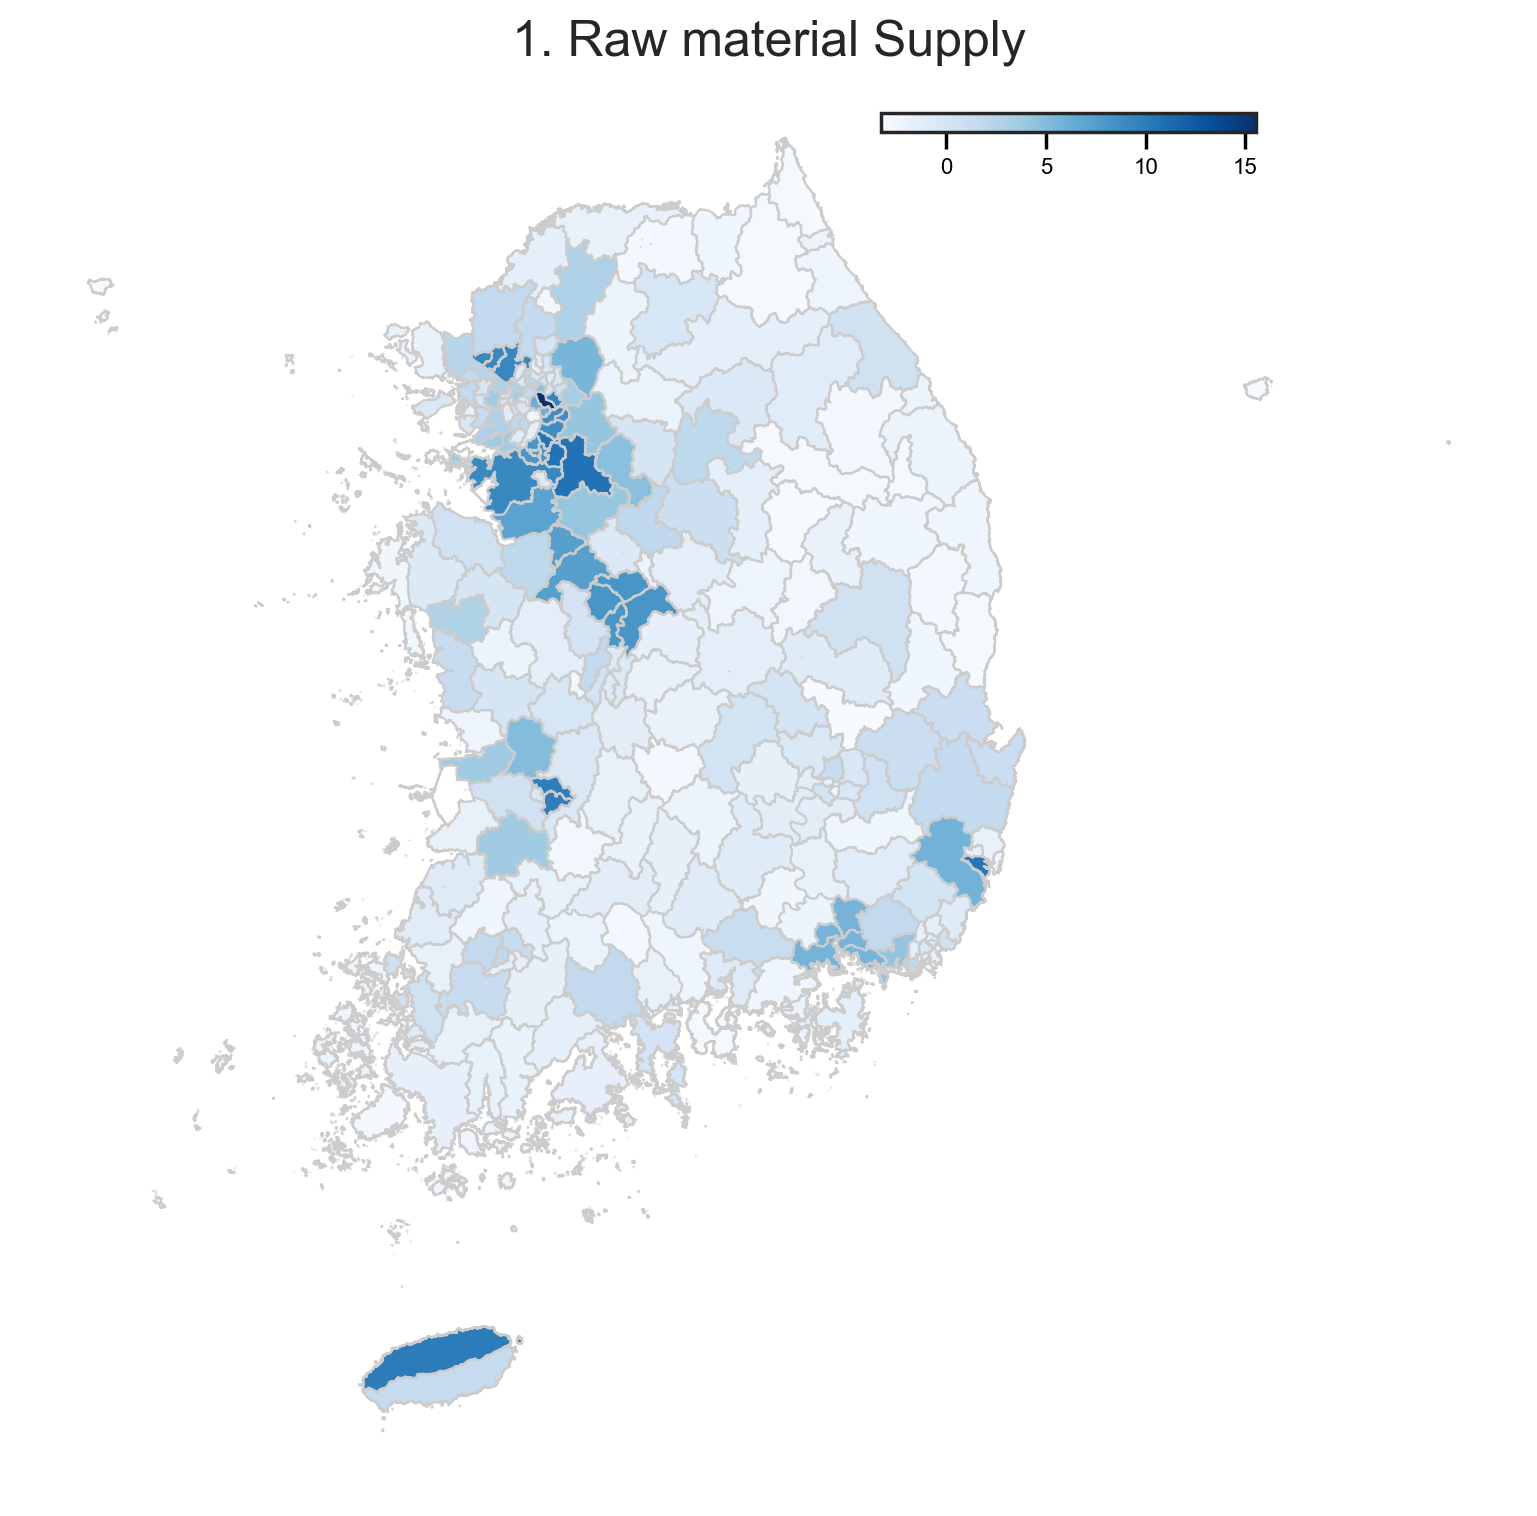

In [41]:
# 시각화
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# 기본 플롯
merged.plot(column='data1_total', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)

# 컬러바 설정
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=merged['data1_total'].min(), vmax=merged['data1_total'].max()))
sm._A = []  # 빈 데이터로 초기화
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.036, pad=0.04)
cbar.ax.tick_params(labelsize=8, colors='black')

# Colorbar 위치 조정
cbar.ax.set_position([0.55, 0.85, 0.125, 0.01])  # [left, bottom, width, height]

# 제목 설정
ax.set_title('1. Raw material Supply', fontdict={'fontsize': '18', 'fontweight': '5'})
ax.set_axis_off()

plt.show()
